In [260]:
import ee
import numpy as np
import pandas as pd

from earthshot import mon_stats
from earthshot import water_viz as vis
from earthshot import normalize as norm
from earthshot import water_common as common
from statistics import mean

import geemap.eefolium as geemap
import folium
from folium import plugins

import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
ee.Initialize()

In [262]:
def NDWI_func(image):
    date_img = image.get('system:time_start')
    NDWI = ((image.select('B4')).subtract(image.select('B6')).subtract(image.select('B7'))).divide((image.select('B4')).add(image.select('B6')).add(image.select('B7')))
    NDWI = NDWI.set({'system:time_start': date_img}).rename('NDWI')
    return NDWI

In [263]:
Landsat_1 = ee.ImageCollection('LANDSAT/LM01/C01/T1').filterDate('1972-07-23', '1975-01-21').map(NDWI_func)
Landsat_2 = ee.ImageCollection('LANDSAT/LM02/C01/T1').filterDate('1975-01-22', '1978-03-04').map(NDWI_func)
Landsat_3 = ee.ImageCollection('LANDSAT/LM03/C01/T1').filterDate('1978-03-05', '1982-07-15').map(NDWI_func)
Landsat_4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_8DAY_NDWI").filterDate('1982-07-16', '1984-02-29').select('NDWI')
Landsat_5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_8DAY_NDWI').filterDate('1984-03-01', '1998-12-31').select('NDWI')
Landsat_7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_8DAY_NDWI').filterDate('1999-01-01', '2013-03-31').select('NDWI')
Landsat_8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDWI').filterDate('2013-04-01', '2021-05-31').select('NDWI')


In [264]:
NDWI_data = Landsat_1.merge(Landsat_2).merge(Landsat_3).merge(Landsat_4).merge(Landsat_5).merge(Landsat_7).merge(Landsat_8)

In [265]:
#NDWI_mean = NDWI_data.mean()

In [349]:
dam_projects = ee.FeatureCollection('users/amgadellaboudy/GRanD_dam_data')

#MAR_projects = ee.FeatureCollection('users/amgadellaboudy/dam_data').filter(ee.Filter.lte('DAM_ID', 1005000))
#MAR_feat = NDVI.sampleRegions(collection = dam_projects, scale = 100, tileScale = 16, geometries = True)
#MAR_feat = NDVI.reduceRegions(collection = dam_projects, reducer = ee.Reducer.mean(), scale = 100, tileScale = 10)
MAR_filtered = dam_projects.filter('YEAR > 1972').filter('YEAR < 2021')

print(MAR_filtered.size().getInfo())

2646


In [350]:
NDWI_years = ee.ImageCollection('users/amgadellaboudy/EVI_year')
NDWI_2020 = (NDWI_data.filter(ee.Filter.date('2020-01-01', '2020-12-31')).reduce(ee.Reducer.mean()))

for i in range(1973,2020):
    NDWI_image = NDWI_data.filter(ee.Filter.date(('{}-01-01'.format(i)), ('{}-12-31'.format(i)))).reduce(ee.Reducer.mean()) #Take moisture index for given year, average values into one image
    NDWI_diff = (NDWI_2020.subtract(NDWI_image)).set({'YEAR': i}) #Store NDWI difference into image, set year as property
    NDWI_years = NDWI_years.merge(NDWI_diff) #Collect into image collection

In [351]:
MAR_1973 = MAR_filtered.filter(ee.Filter.eq('YEAR', 1973))  #Initialize MAR Feature Collection for year 1973
NDWI_1973 = NDWI_years.filter(ee.Filter.eq('YEAR', 1973)).first() #Take image for NDVI diff for 1973
NDWI_1973_feat = NDWI_1973.sampleRegions(collection = MAR_1973, properties = ['YEAR'], scale = 100, tileScale = 16, geometries = True) #Initiate image collection for EVI diff at MAR locations

for i in range(1974,2020):
    MAR_year = MAR_filtered.filter(ee.Filter.eq('YEAR', i))
    NDWI_set = NDWI_years.filter(ee.Filter.eq('YEAR', i)).first()
    NDWI_feat = NDWI_set.sampleRegions(collection = MAR_year, properties = ['YEAR'], scale = 100, tileScale = 16, geometries = True)
    NDWI_1973_feat = NDWI_1973_feat.merge(NDWI_feat)

In [353]:
def success(feature):
    success_feat = feature.set({'Success': 1})
    return success_feat

def fail(feature):
    fail_feat = feature.set({'Success': 0})
    return fail_feat

NDWI_success = NDWI_1973_feat.filter(ee.Filter.gt('NDWI_mean', 0)).map(success)
NDWI_fail = NDWI_1973_feat.filter(ee.Filter.lte('NDWI_mean', 0)).map(fail)
NDWI_data_feat = NDWI_success.merge(NDWI_fail)

def success(feature):
    success_feat = feature.set({'Success': 1})
    return success_feat

def fail(feature):
    fail_feat = feature.set({'Success': 0})
    return fail_feat

dam_success = MAR_feat.filter(ee.Filter.gt('ndvi', 0.5)).map(success)
dam_fail = MAR_feat.filter(ee.Filter.lte('ndvi', 0.5)).map(fail)
dam_feat = dam_success.merge(dam_fail)

#print(NDWI_success.size().getInfo())

In [1]:
#Import variables in (Slope, Porosity, Runoff, Soil Types, Annual Precipitation, water accumulation)
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#Scale = 90 m

smap_usda_clim = ee.ImageCollection('users/jamesmcc/smap_usda_climatology')
avail_porosity = (smap_usda_clim
                  .filter(ee.Filter.eq('band', 'avail_porosity_mm')))
avail_porosity_img = avail_porosity.sum()

runoff_clim = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('surface_runoff')
runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)

precip_clim = ee.Image("OpenLandMap/CLM/CLM_PRECIPITATION_SM2RAIN_M/v01")
precip_img = precip_clim.reduce('sum')
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_CLM_CLM_PRECIPITATION_SM2RAIN_M_v01#bands
#Scale = 1 km

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')})

bottom_soils = soil_types.expression('soil_60 + soil_100 + soil_200',
                                 {'soil_60': soil_types.select('b60'),
                                  'soil_100': soil_types.select('b100'),
                                  'soil_200': soil_types.select('b200')})



water_img = ee.Image("MERIT/Hydro/v1_0_1").select('upa')
#https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#bands
#Scale = 90 m

#Measure of water accumulation: https://developers.google.com/earth-engine/datasets/catalog/WWF_HydroSHEDS_15ACC
#Scale = 462 m



NameError: name 'ee' is not defined

In [355]:
#Collect images into one image, convert into feature collection that includes location and type of MAR interventions

img_1 = slope_img.addBands(water_img)
img_2 = img_1.addBands(runoff_img)
img_3 = img_2.addBands(top_soils)
img_4 = img_3.addBands(land_use)
training_img = img_4.addBands(bottom_soils)

print(training_img.bandNames().getInfo())

['slope', 'upa', 'surface_runoff', 'b0', 'discrete_classification', 'b60']


In [433]:
target = 'Success'
bands = ['slope', 'upa', 'surface_runoff', 'b0', 'discrete_classification', 'b60']

#training = training_img.sampleRegions(collection= NDWI_data_feat, properties = [target], scale = 500, geometries = True)
training = training_img.sampleRegions(collection= NDWI_data_feat, scale = 100, tileScale = 16, geometries = True)

xx = ee.batch.Export.table.toAsset(training,
                                   assetId= 'users/amgadellaboudy/Training_table_GrAND',
                                   description = 'Table_Task' ).start()

In [434]:
training = ee.FeatureCollection('users/amgadellaboudy/Training_table_GrAND')

In [435]:
#Test/ validation split, fit classifier for training data

split = 0.7
training = training.randomColumn()

training_split = training.filter(ee.Filter.lt('random', split))
validation_split = training.filter(ee.Filter.gte('random', split))

classifier = ee.Classifier.smileGradientTreeBoost(2000).train(features= training_split, classProperty= target, inputProperties = bands)

In [436]:
#Create predicted MAR intervention image and validation data

classified = training_split.classify(classifier)
validated = validation_split.classify(classifier)

In [437]:
#Training accuracy

trainAccuracy = classified.errorMatrix('Success', 'classification')
print('Resubstitution error matrix: ', trainAccuracy.getInfo())
print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())

Resubstitution error matrix:  [[134, 0], [0, 338]]
Training overall accuracy:  1


In [438]:
#Validation accuracy

validationAccuracy = validated.errorMatrix('Success', 'classification')
print('Validation error matrix: ', validationAccuracy.getInfo())
print('Validation overall accuracy: ', validationAccuracy.accuracy().getInfo())

Validation error matrix:  [[11, 41], [21, 122]]
Validation overall accuracy:  0.6820512820512821


In [439]:
classified_img = training_img.classify(classifier)

In [440]:
#NDVI_image = NDVI_data.filter(ee.Filter.date('2000-01-01', '2000-12-31')).reduce(ee.Reducer.mean()) #Take vegetation index for given year, average values into one image
#NDVI_diff = (NDVI_2020.subtract(NDVI_image)) #Store NDVI difference into image, set year as property

In [441]:
the_map = geemap.Map()

Landsat = ee.ImageCollection('LANDSAT/LM03/C01/T1')

vis_params = {
    'min': 0, 'max': 1, 'dimensions': 512,
    'palette': ['Red', 'Blue']}

flowAccumulationVis = {
  'min': 0.0,
  'max': 500.0,
  'palette': [
    '000000', '023858', '006837', '1a9850', '66bd63', 'a6d96a', 'd9ef8b',
    'ffffbf', 'fee08b', 'fdae61', 'f46d43', 'd73027'
  ]}

the_map.addLayer(classified_img, vis_params, 'Classification')
the_map.addLayer(water_img, flowAccumulationVis, 'Water')
the_map.addLayer(training.draw(color= '006600', pointRadius = 5, strokeWidth= 5), {}, name = 'MAR locations')

vis.folium_display(the_map)

In [442]:
import requests
from IPython.display import Image, display

In [443]:
response = requests.get(url = 'http://taginfo.openstreetmap.org/api/4/key/distribution/nodes?key=waterway')

In [444]:
response.raise_for_status()

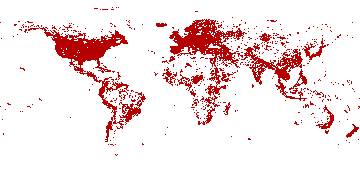

In [445]:
display(Image(response.content))